In [175]:
import datetime

import psycopg2
import psycopg2.extras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Collection

Needed to gather historical data regarding player, teams, etc.

Fortunately, [ESPN Scrum](espnscrum.com) provides a data on players, teams, and matches going back to 1896.

### Building ```rugby_pg.db```
* Using a scrapy spider built by peloyeje (found [here](https://github.com/peloyeje/map536-rugby-data-scraper)), it was possible to collect a meaningful sample of matches and results, along with player stats for each match to work with.

* After scraping player, team, and match stats from ESPN Scrum the data was inserted into a SQLite database.
    * Although SQLite format is perfectly fine to work with, we have more experience with PostgreSQL. 
    * To make things easier for ourselves, we converted the SQLite into a PostgreSQL database.
  
### Building ```rankings.csv```
* The World Rugby rankings were gathered from [World Rugby's website](https://www.world.rugby/rankings/mru?lang=en) using Beautiful Soup.

* We were able to gather data points containing ```team_name```, ```abbreviation```, ```num_matches```, ```pts```, ```pos```, ```prev_pts```, ```prev_pos```, ```data```.

    * Each data point represents a single team's data from the given date.

    * World Rugby began recording this data on November 2003, so unfortunately there are many years of competition that are not represented in the data set.
    
* The scraping process was done outside of a Jupyter Notebook, due to the heavy memory consumption required to build this large data set

    * Instead, by creating ```csv_writer.py``` and running this python program on a machine with high-spec hardware, the data set ```rankings.csv``` was built.

In [176]:
'''This is the code from csv_writer.py --- it has been commented out to prevent the Jupyter Notebook from building the data set'''


# import json
# import requests
# from bs4 import BeautifulSoup

# from datetime import timedelta, date

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# import csv

# def daterange(start_date, end_date):
#     for n in range(int ((end_date - start_date).days)):
#         yield start_date + timedelta(n)

# start_date = date(2003, 10, 13)
# end_date = date(2019, 11, 15)

# csv_data = [['team_name', 'abbreviation', 'num_matches', 'pts', 'pos', 'prev_pts', 'prev_pos', 'date']]

# for single_date in daterange(start_date, end_date):
#     date = single_date.strftime("%Y-%m-%d")

#     ranking_url = "cmsapi.pulselive.com/rugby/rankings/mru?date=%s&client=pulse" % date
#     r  = requests.get("http://" + ranking_url)

#     soup = BeautifulSoup(r.text)

#     data = json.loads(soup.body.p.text)
#     for entry in data['entries']:
#         csv_data.append(
#             [entry['team']['name'], entry['team']['abbreviation'], 
#              entry['matches'], entry['pts'], entry['pos'], entry['previousPts'], 
#              entry['previousPos'], date]
#         )

# with open('rankings.csv', 'w') as csv_file:
#     writer = csv.writer(csv_file)
#     writer.writerows(csv_data)
# csv_file.close()

'This is the code from csv_writer.py --- it has been commented out to prevent the Jupyter Notebook from building the data set'

# Data Visualization -

## Preprocessing ```rankings.csv```

In [177]:
data = pd.read_csv("ranking_data/rankings.csv")

data

,team_name,abbreviation,num_matches,pts,pos,prev_pts,prev_pos,date
0,England,ENG,11,89.948520,1,89.948520,1,2003-10-13
1,New Zealand,NZL,11,89.797710,2,89.797710,2,2003-10-13
2,Australia,AUS,11,84.762690,3,83.805620,4,2003-10-13
3,Ireland,IRE,11,83.924580,4,83.924580,3,2003-10-13
4,France,FRA,11,82.845314,5,82.845314,5,2003-10-13
...,...,...,...,...,...,...,...,...
577110,Monaco,MON,12,23.171558,101,23.171558,101,2019-11-14
577111,Greece,GRE,17,22.546452,102,22.546452,102,2019-11-14
577112,Indonesia,INA,5,21.891422,103,21.891422,103,2019-11-14
577113,Vanuatu,VAN,16,21.453693,104,21.453693,104,2019-11-14


Using Python library ```matplotlib```, we were able to create a few graphs from the ```rankings.csv``` dataset.

We mainly explored the dynamics between the top ranking teams.

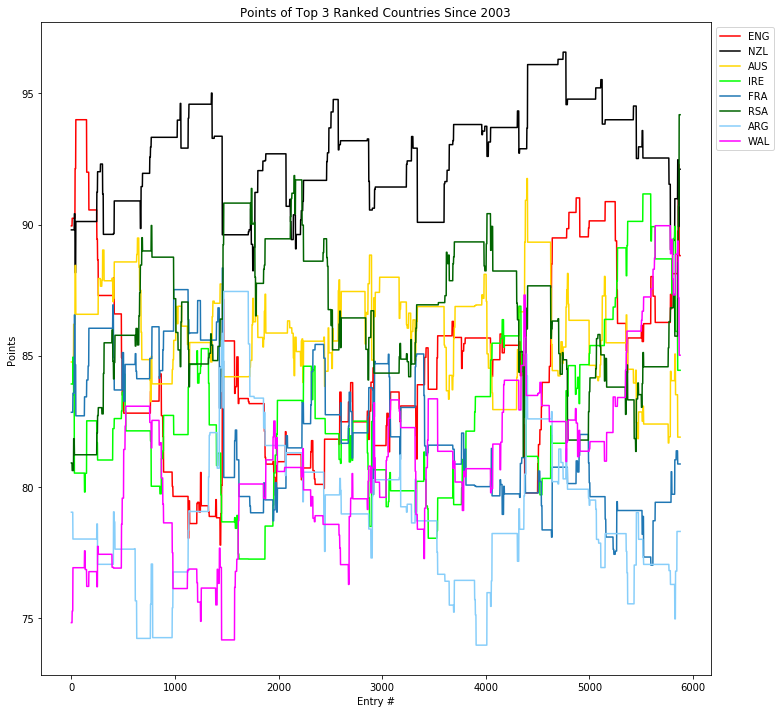

In [178]:
fig = plt.figure(figsize=(12, 12))

for abbr in data.loc[data.pos < 4].abbreviation.unique():
    abbr_pts = data.loc[data.abbreviation == abbr].values[:,[3]]
    if abbr == 'NZL':
        plt.plot(abbr_pts, label = abbr, color = 'black')
    elif abbr == 'ENG':
        plt.plot(abbr_pts, label = abbr, color = 'red')
    elif abbr == 'AUS':
        plt.plot(abbr_pts, label = abbr, color = 'gold')
    elif abbr == 'RSA':
        plt.plot(abbr_pts, label = abbr, color = 'darkgreen')
    elif abbr == 'IRE':
        plt.plot(abbr_pts, label = abbr, color = 'lime')
    elif abbr == 'ARG':
        plt.plot(abbr_pts, label = abbr, color = 'lightskyblue')
    elif abbr == 'WAL':
        plt.plot(abbr_pts, label = abbr, color = 'magenta')
    else:
        plt.plot(abbr_pts, label = abbr)
    
plt.title("Points of Top 3 Ranked Countries Since 2003")
plt.xlabel("Entry #")
plt.ylabel("Points")
ax = plt.gca()
plt.legend(bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
plt.show()

This data is very noisy and does not allow easy understanding of the situation being represented.

- To improve understanding, we will now take the average points per year, rather than the points on each date.

The following table was created directly from 'rankings.csv' by first inserting the file into a postgres server and then using the SQL command:<br />
~~~~sql
    SELECT team_name, pos, extract(year FROM date) AS year, AVG(points)
    FROM rankings
    GROUP BY team_name, pos, year
    HAVING pos < 4
    ORDER BY year;
~~~~

In [179]:
data = pd.read_csv("ranking_data/avg_pts_perteam_perpos_peryr.csv")

data

,team_name,pos,year,avg
0,Australia,2,2003,88.441790
1,Australia,3,2003,86.103692
2,England,1,2003,92.347882
3,England,2,2003,90.238914
4,France,3,2003,86.553150
...,...,...,...,...
119,South Africa,1,2019,94.185720
120,South Africa,2,2019,90.712790
121,Wales,1,2019,89.432526
122,Wales,2,2019,89.782635


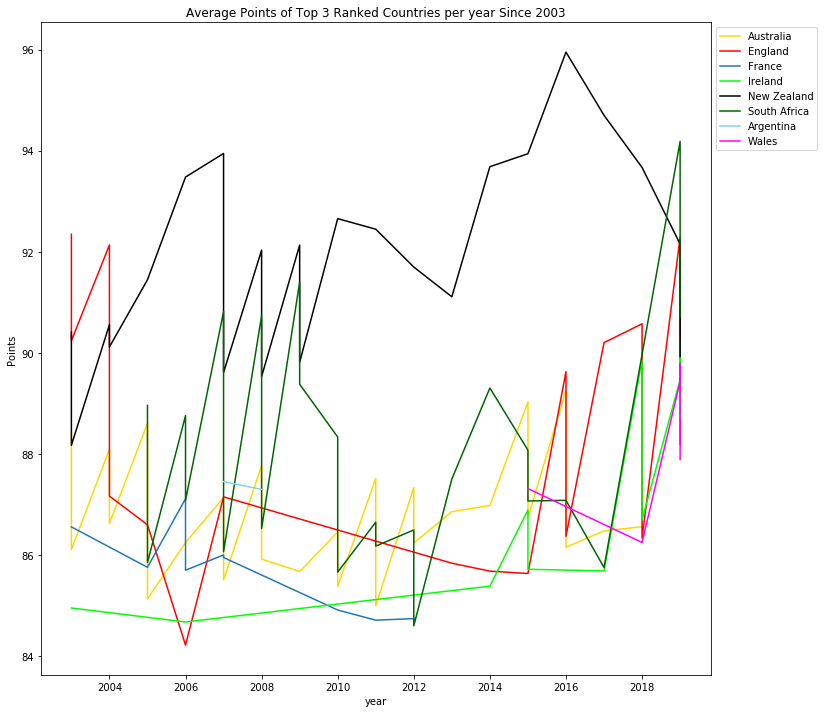

In [180]:
fig = plt.figure(figsize=(12, 12))

for team in data.loc[data.pos < 4].team_name.unique():
    points = data.loc[data.team_name == team].values[:,[3]]
    date = data.loc[data.team_name == team].values[:,[2]]
    if team == 'New Zealand':
        plt.plot(date, points, label = team, color = 'black')
    elif team == 'England':
        plt.plot(date, points, label = team, color = 'red')
    elif team == 'Australia':
        plt.plot(date, points, label = team, color = 'gold')
    elif team == 'South Africa':
        plt.plot(date, points, label = team, color = 'darkgreen')
    elif team == 'Ireland':
        plt.plot(date, points, label = team, color = 'lime')
    elif team == 'Argentina':
        plt.plot(date, points, label = team, color = 'lightskyblue')
    elif team == 'Wales':
        plt.plot(date, points, label = team, color = 'magenta')
    else:
        plt.plot(date, points, label = team)

    
plt.title("Average Points of Top 3 Ranked Countries per year Since 2003")
plt.xlabel("year")
plt.ylabel("Points")
ax = plt.gca()
plt.legend(bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
plt.show()

We also notice that there are only 8 teams that have only ever been ranked in the top 3 positions, and we verified this by querying the 'rankings.csv' data with:
~~~~sql
SELECT DISTNCT team_name
FROM rankings
WHERE pos < 4;
~~~~

From here, we looked at the average ranking of these teams from 2003 to 2019 to get a better sense of the consistently top ranked teams. The query follows:
~~~~sql
SELECT team_name, AVG(pos) AS average_position
FROM rankings
GROUP BY team_name
HAVING team_name = 'New Zealand'
OR team_name = 'Australia'
OR team_name = 'England'
OR team_name = 'South Africa'
OR team_name = 'France'
OR team_name = 'Ireland'
OR team_name = 'Argentina'
OR team_name = 'Wales'
ORDER BY average_position;
~~~~

In [181]:
data = pd.read_csv("ranking_data/avg_pos.csv")

data

,team_name,average_position
0,New Zealand,1.119789
1,South Africa,3.254722
2,Australia,3.334354
3,England,4.419772
4,Ireland,5.297771
5,France,5.671941
6,Wales,6.401225
7,Argentina,7.638081


We also looked at the worst ranking of these teams from 2003 to 2019 for similar reasons. Again, the query follows:
~~~~sql
SELECT team_name, MAX(pos) AS worst_position
FROM rankings
GROUP BY team_name
HAVING team_name = 'New Zealand'
OR team_name = 'Australia'
OR team_name = 'England'
OR team_name = 'South Africa'
OR team_name = 'France'
OR team_name = 'Ireland'
OR team_name = 'Argentina'
OR team_name = 'Wales'
ORDER BY worst_position;
~~~~

In [182]:
data = pd.read_csv("ranking_data/worst_pos.csv")

data

,team_name,worst_position
0,New Zealand,3
1,South Africa,7
2,Australia,7
3,England,8
4,Ireland,9
5,Wales,10
6,France,10
7,Argentina,12


## Preprocessing ```rugby_pg.db```

Using pg_restore on ```rugby_pg.db``` we created a PostgreSQL database. We can interact with the database using Python library, ```pscopg2```.

In [183]:
conn = psycopg2.connect(dbname="rugby", user="postgres", password="postgres")
cur = conn.cursor(cursor_factory = psycopg2.extras.DictCursor)

cur.execute("""
        SELECT *
        FROM
          (SELECT id, date, match_type
           FROM matchs) match_date
        JOIN
          (SELECT *
           FROM matchstats
           JOIN teams ON teams.id = matchstats.team_id) match_team ON match_date.id = match_team.match_id 
        WHERE date > '2003-10-12'::date;
    """)
data = cur.fetchall()

match_data = pd.DataFrame([i.copy() for i in data])
rankings_data = pd.read_csv("ranking_data/rankings.csv")

In [184]:
'''This is the code used to gather the ranking position and points for each team on the date of their match --- it has been commented out to prevent the Jupyter Notebook from building the data set'''

# match_data.date = match_data.date.astype(str)
# rankings_data.date = rankings_data.date.astype(str)

# ordered_pos = []
# ordered_pts = []

# for rec in match_data.itertuples():
#     if rankings_data.loc[(rankings_data.team_name == rec.name) & (rankings_data.date == rec.date)].empty:
#         ordered_pos.append(-1)
#         ordered_pts.append(-1)
#     else:
#         ordered_pos.append(
#             rankings_data.loc[
#                 (rankings_data.team_name == rec.name) & (rankings_data.date == rec.date)
#             ].values[:,[4]][0][0])

#         ordered_pts.append(
#             rankings_data.loc[
#                 (rankings_data.team_name == rec.name) & (rankings_data.date == rec.date)
#             ].values[:,[3]][0][0])

# match_data['pos'] = ordered_pos
# match_data['pts'] = ordered_pts

# export_csv = match_data.to_csv(r'merged.csv', index = None, header=True)

'This is the code used to gather the ranking position and points for each team on the date of their match --- it has been commented out to prevent the Jupyter Notebook from building the data set'

In [185]:
match_rank_data = pd.read_csv('merged.csv')

match_rank_data

,id,date,match_type,match_id,team_id,scored,conceded,tries,cons,pens,drops,name,pos,pts
0,8,2019-11-01,3,298261,8,40,17,6.0,2.0,0.0,0.0,New Zealand,3,89.923170
1,1,2019-11-02,3,298262,1,12,32,0.0,0.0,2.0,0.0,England,1,92.289230
2,5,2019-11-02,3,298262,5,32,12,2.0,2.0,2.0,0.0,South Africa,2,90.712790
3,5,2019-10-27,3,298260,5,19,16,1.0,1.0,2.0,0.0,South Africa,4,88.548485
4,85,2019-11-02,1,303988,85,38,9,NaN,NaN,NaN,NaN,Austria,88,32.555595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8419,16,2003-10-15,3,24561,16,12,36,2.0,1.0,0.0,0.0,Tonga,12,70.075780
8420,14,2003-10-15,3,24560,14,19,18,1.0,1.0,2.0,0.0,Fiji,11,72.446686
8421,11,2003-10-15,3,24560,11,18,19,2.0,1.0,2.0,0.0,United States of America,-1,-1.000000
8422,10,2003-10-14,3,24559,10,67,14,9.0,2.0,1.0,0.0,Argentina,7,79.038790


Using the tables gathered from ESPN Scrum, we were able to calculate each team's total win percentage over all games they have played. 

The code to obtain this table is given below with the query:
~~~~sql
SELECT x.name, x.num_matches, y.total_wins, (y.total_wins::NUMERIC / x.num_matches::NUMERIC * 100.0::NUMERIC)::NUMERIC AS win_percentage
FROM (SELECT teams.name, COUNT(*) AS num_matches
      FROM teams JOIN matchstats ON teams.id = matchstats.team_id
      GROUP BY teams.name) x
      JOIN (SELECT a.name, (a.home_wins + b.away_wins) AS total_wins
            FROM (SELECT teams.name, COUNT(matchs.won) AS home_wins
                  FROM teams
                  JOIN matchs ON teams.id = matchs.home_team_id
                  GROUP BY teams.name, matchs.won
                  HAVING won = 1) a
            JOIN (SELECT teams.name, COUNT(matchs.won) AS away_wins
                  FROM teams JOIN matchs ON teams.id = matchs.away_team_id
                  GROUP BY teams.name, matchs.won
                  HAVING won = 2) b
      ON a.name = b.name) y
ON x.name = y.name
ORDER BY win_percentage DESC;
~~~~

In [186]:
cur.execute("""
        SELECT x.name, x.num_matches, y.total_wins, (y.total_wins::NUMERIC / x.num_matches::NUMERIC * 100.0::NUMERIC)::NUMERIC AS win_percentage
        FROM (SELECT teams.name, COUNT(*) AS num_matches
              FROM teams JOIN matchstats ON teams.id = matchstats.team_id
              GROUP BY teams.name) x
              JOIN (SELECT a.name, (a.home_wins + b.away_wins) AS total_wins
                    FROM (SELECT teams.name, COUNT(matchs.won) AS home_wins
                          FROM teams
                          JOIN matchs ON teams.id = matchs.home_team_id
                          GROUP BY teams.name, matchs.won
                          HAVING won = 1) a
                    JOIN (SELECT teams.name, COUNT(matchs.won) AS away_wins
                          FROM teams JOIN matchs ON teams.id = matchs.away_team_id
                          GROUP BY teams.name, matchs.won
                          HAVING won = 2) b
              ON a.name = b.name) y
        ON x.name = y.name
        ORDER BY win_percentage DESC;
    """)
data = cur.fetchall()
win_percentage_data = pd.DataFrame([i.copy() for i in data])
win_percentage_data

,name,num_matches,total_wins,win_percentage
0,Gibraltar,4,4,100.000000000000000000000
1,Qatar,14,12,85.714285714285714286000
2,New Zealand,311,254,81.672025723472668810000
3,Armenia,28,20,71.428571428571428571000
4,Burkina Faso,33,23,69.696969696969696970000
...,...,...,...,...
132,Uzbekistan,22,5,22.727272727272727273000
133,El Salvador,18,4,22.222222222222222222000
134,St Lucia,14,3,21.428571428571428571000
135,Benin,32,6,18.750000000000000000000


However, we notice that there needs to be some cleaning in the data because there are teams that have only played a handful of matches. 
- These win percentages can be quite misleading, as some teams have not played a meaningful amount of games.
    - To remove these misleading statistics, we set a new criteria of **having at least 50 games played**.
    - After cleaning the data (using the condition that the minimum number of games played be 50) we obtain the processed table below:

            name  num_matches  total_wins            win_percentage
0    New Zealand          311         254  81.672025723472668810000
1        England          292         188  64.383561643835616438000
2   South Africa          326         202  61.963190184049079755000
3        Georgia          215         133  61.860465116279069767000
4      Australia          324         199  61.419753086419753086000
..           ...          ...         ...                       ...
65         Chile          127          42  33.070866141732283465000
66       Austria          106          34  32.075471698113207547000
67         Italy          275          84  30.545454545454545455000
68       Finland           69          21  30.434782608695652174000
69        Norway           94          28  29.787234042553191489000

[70 rows x 4 columns]


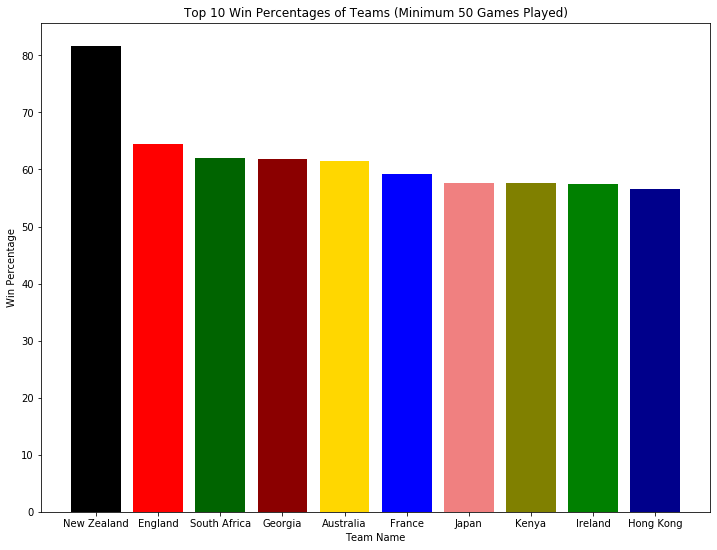

In [187]:
cur.execute("""
        SELECT x.name, x.num_matches, y.total_wins, (y.total_wins::NUMERIC / x.num_matches::NUMERIC * 100.0::NUMERIC)::NUMERIC AS win_percentage
        FROM (SELECT teams.name, COUNT(*) AS num_matches
              FROM teams JOIN matchstats ON teams.id = matchstats.team_id
              GROUP BY teams.name) x
        JOIN (SELECT a.name, (a.home_wins + b.away_wins) AS total_wins
                    FROM (SELECT teams.name, COUNT(matchs.won) AS home_wins
                          FROM teams
                          JOIN matchs ON teams.id = matchs.home_team_id
                          GROUP BY teams.name, matchs.won
                          HAVING won = 1) a
                    JOIN (SELECT teams.name, COUNT(matchs.won) AS away_wins
                          FROM teams JOIN matchs ON teams.id = matchs.away_team_id
                          GROUP BY teams.name, matchs.won
                          HAVING won = 2) b
              ON a.name = b.name) y
        ON x.name = y.name
        WHERE x.num_matches > 49
        ORDER BY win_percentage DESC;
    """)
data = cur.fetchall()

win_percentage_data = pd.DataFrame([i.copy() for i in data])

print(win_percentage_data)

fig = plt.figure(figsize=(12, 9))

win_percentage_data.win_percentage = win_percentage_data.win_percentage.astype(float)
top_win_percentage_data = win_percentage_data.nlargest(10, 'win_percentage')

plt.bar(top_win_percentage_data.name, top_win_percentage_data.win_percentage, color = ['black', 'red', 'darkgreen', 'darkred', 'gold', 'blue', 'lightcoral', 'olive', 'green', 'darkblue'])
plt.title("Top 10 Win Percentages of Teams (Minimum 50 Games Played)")
plt.ylabel("Win Percentage")
plt.xlabel("Team Name")
plt.show()

Looking at teams with a minimum 50 games played has allowed us to remove many teams with unmeaningful records, but these statistics are still quite misleading. 
- The main issue being, tier 2 teams such as Kenya and Hong Kong do not play against the same caliber opposition when compared to tier 1 teams like New Zealand and England.
    - To remove these misleading statistics, we set a raise our criteria to **having at least 250 games played**.
    - After cleaning the data (using the condition that the minimum number of games played be 250) we obtain the processed table below:

            name  num_matches  total_wins            win_percentage
0    New Zealand          311         254  81.672025723472668810000
1        England          292         188  64.383561643835616438000
2   South Africa          326         202  61.963190184049079755000
3      Australia          324         199  61.419753086419753086000
4         France          314         186  59.235668789808917197000
5          Japan          260         150  57.692307692307692308000
6        Ireland          280         161  57.500000000000000000000
7      Argentina          289         153  52.941176470588235294000
8          Wales          316         163  51.582278481012658228000
9       Scotland          276         120  43.478260869565217391000
10         Italy          275          84  30.545454545454545455000


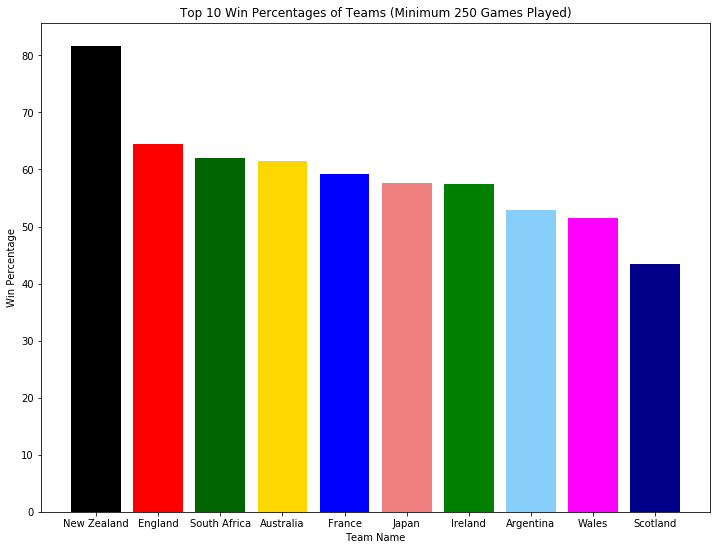

In [188]:
cur.execute("""
        SELECT x.name, x.num_matches, y.total_wins, (y.total_wins::NUMERIC / x.num_matches::NUMERIC * 100.0::NUMERIC)::NUMERIC AS win_percentage
        FROM (SELECT teams.name, COUNT(*) AS num_matches
              FROM teams JOIN matchstats ON teams.id = matchstats.team_id
              GROUP BY teams.name) x
        JOIN (SELECT a.name, (a.home_wins + b.away_wins) AS total_wins
                    FROM (SELECT teams.name, COUNT(matchs.won) AS home_wins
                          FROM teams
                          JOIN matchs ON teams.id = matchs.home_team_id
                          GROUP BY teams.name, matchs.won
                          HAVING won = 1) a
                    JOIN (SELECT teams.name, COUNT(matchs.won) AS away_wins
                          FROM teams JOIN matchs ON teams.id = matchs.away_team_id
                          GROUP BY teams.name, matchs.won
                          HAVING won = 2) b
              ON a.name = b.name) y
        ON x.name = y.name
        WHERE x.num_matches > 249
        ORDER BY win_percentage DESC;
    """)
data = cur.fetchall()

win_percentage_data = pd.DataFrame([i.copy() for i in data])

print(win_percentage_data)

fig = plt.figure(figsize=(12, 9))

win_percentage_data.win_percentage = win_percentage_data.win_percentage.astype(float)
top_win_percentage_data = win_percentage_data.nlargest(10, 'win_percentage')

plt.bar(top_win_percentage_data.name, top_win_percentage_data.win_percentage, color = ['black', 'red', 'darkgreen', 'gold', 'blue', 'lightcoral', 'green', 'lightskyblue', 'magenta', 'darkblue'])
plt.title("Top 10 Win Percentages of Teams (Minimum 250 Games Played)")
plt.ylabel("Win Percentage")
plt.xlabel("Team Name")
plt.show()

These percentages show teams that compete against eachother regularly, so comparing them is more meaningful than comparing teams who likely never face eachother.